In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# build the model with keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [17]:
df = pd.read_csv('datawithfold.csv', usecols=lambda column: column != 'Unnamed: 0')

# Separate the features (x) and the target variable (y)
x = df.drop(['y', 'fold'], axis=1)
y = df['y']

# Split the data into train and test sets based on the fold column
x_train = x[df['fold'] == 1]
y_train = y[df['fold'] == 1]
x_test = x[df['fold'] == 0]
y_test = y[df['fold'] == 0]
# separate train to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=3, stratify=y_train)
# convert target tensors to one-hot encoded format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
# remove first column
y_train = np.delete(y_train, 0, 1)
y_val = np.delete(y_val, 0, 1)
y_test = np.delete(y_test, 0, 1)

# train nn to predict genre, there are 6 genres, from 1 to 6
classes = {'edm': 1, 'latin': 2, 'pop': 3, 'r&b': 4, 'rap': 5, 'rock': 6}

# build the model
model = Sequential()
model.add(Dense(256, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/500
381/381 [==============================] - 1s 1ms/step - loss: 1.4373 - accuracy: 0.4304 - val_loss: 1.3089 - val_accuracy: 0.5044
Epoch 2/500
381/381 [==============================] - 0s 958us/step - loss: 1.3379 - accuracy: 0.4860 - val_loss: 1.2929 - val_accuracy: 0.5170
Epoch 3/500
381/381 [==============================] - 0s 958us/step - loss: 1.3069 - accuracy: 0.4993 - val_loss: 1.2979 - val_accuracy: 0.5126
Epoch 4/500
381/381 [==============================] - 0s 936us/step - loss: 1.2929 - accuracy: 0.5034 - val_loss: 1.2707 - val_accuracy: 0.5369
Epoch 5/500
381/381 [==============================] - 0s 935us/step - loss: 1.2698 - accuracy: 0.5117 - val_loss: 1.2506 - val_accuracy: 0.5325
Epoch 6/500
381/381 [==============================] - 0s 1ms/step - loss: 1.2566 - accuracy: 0.5195 - val_loss: 1.2678 - val_accuracy: 0.5436
Epoch 7/500
381/381 [==============================] - 0s 1ms/step - loss: 1.2383 - accuracy: 0.5305 - val_loss: 1.2506 - val_accuracy

In [ ]:
# evaluate the model
score = model.evaluate(x_test, y_test)
print(score)

# plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# predict the test data
model = model.load_weights('best_model.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
# create optuna study to find the best hyperparameters
import optuna
from keras import backend as K
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

df = pd.read_csv('datawithfold.csv', usecols=lambda column: column != 'Unnamed: 0')

# Separate the features (x) and the target variable (y)
x = df.drop(['y', 'fold'], axis=1)
y = df['y']

# Split the data into train and test sets based on the fold column
x_train = x[df['fold'] == 1]
y_train = y[df['fold'] == 1]
x_test = x[df['fold'] == 0]
y_test = y[df['fold'] == 0]
# separate train to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=3, stratify=y_train)
# convert target tensors to one-hot encoded format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
# remove first column
y_train = np.delete(y_train, 0, 1)
y_val = np.delete(y_val, 0, 1)
y_test = np.delete(y_test, 0, 1)

# train nn to predict genre, there are 6 genres, from 1 to 6
classes = {'edm': 1, 'latin': 2, 'pop': 3, 'r&b': 4, 'rap': 5, 'rock': 6}

# build the model
def create_model(trial, rate, lr, wd):

    model = Sequential()
    model.add(Dense(256, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dropout(rate))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dropout(rate))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Dropout(rate))
    model.add(Dense(6, activation='softmax'))

    # compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr), metrics=['accuracy'])    
    return model

# define the objective function
def objective(trial):
    # clear clutter from previous session graphs.
    K.clear_session()

    # generate hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [100, 200, 300, 400, 500])
    # weight decay
    wd = trial.suggest_float('wd', 1e-6, 1e-3, log=True)
    # dropout rate
    rate = trial.suggest_float('rate', 0.1, 0.5, step=0.1)
    # learning rate
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)

    # create the model
    model = create_model(trial, rate, lr, wd)

    # train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

    # evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]

    return accuracy

# create the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# print the best hyperparameters
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best hyperparameters: {}'.format(trial.params))


[I 2023-12-28 17:34:40,797] A new study created in memory with name: no-name-7c27f8ad-8838-4627-bdeb-ec2611389545
[I 2023-12-28 17:36:11,711] Trial 0 finished with value: 0.4939374625682831 and parameters: {'batch_size': 64, 'epochs': 300, 'wd': 8.450723019699623e-05, 'rate': 0.4, 'lr': 2.637847829177469e-06}. Best is trial 0 with value: 0.4939374625682831.
[I 2023-12-28 17:37:27,756] Trial 1 finished with value: 0.5475430488586426 and parameters: {'batch_size': 128, 'epochs': 400, 'wd': 0.00047843234889835844, 'rate': 0.5, 'lr': 0.0007359649707048167}. Best is trial 1 with value: 0.5475430488586426.
[I 2023-12-28 17:38:05,508] Trial 2 finished with value: 0.5022335648536682 and parameters: {'batch_size': 128, 'epochs': 200, 'wd': 2.152414930899488e-06, 'rate': 0.1, 'lr': 0.00030884101270194114}. Best is trial 1 with value: 0.5475430488586426.
[I 2023-12-28 17:39:37,247] Trial 3 finished with value: 0.5137205123901367 and parameters: {'batch_size': 32, 'epochs': 200, 'wd': 0.0007951631

Accuracy: 0.5622208118438721
Best hyperparameters: {'batch_size': 64, 'epochs': 300, 'wd': 0.00010918659567535435, 'rate': 0.5, 'lr': 2.2284667562332993e-05}


In [35]:
# train the model with the best hyperparameters
model = create_model(study.best_trial, study.best_trial.params['rate'], study.best_trial.params['lr'], study.best_trial.params['wd'])
history = model.fit(x_train, y_train, epochs=study.best_trial.params['epochs'], batch_size=study.best_trial.params['batch_size'], validation_split=0.1, verbose=0)

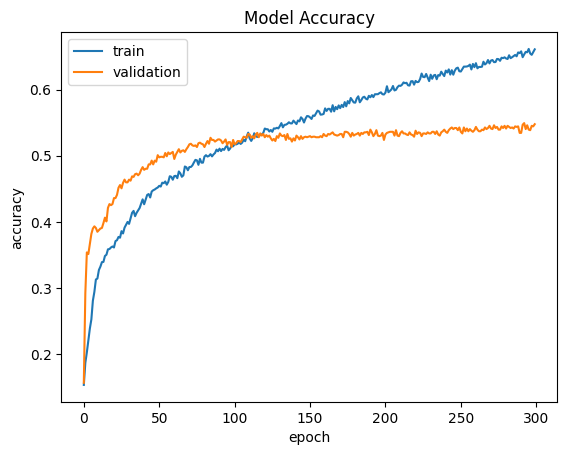

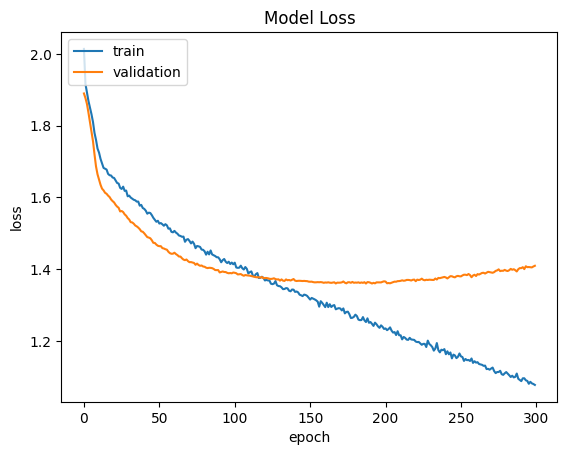

49/49 [==============================] - 0s 582us/step


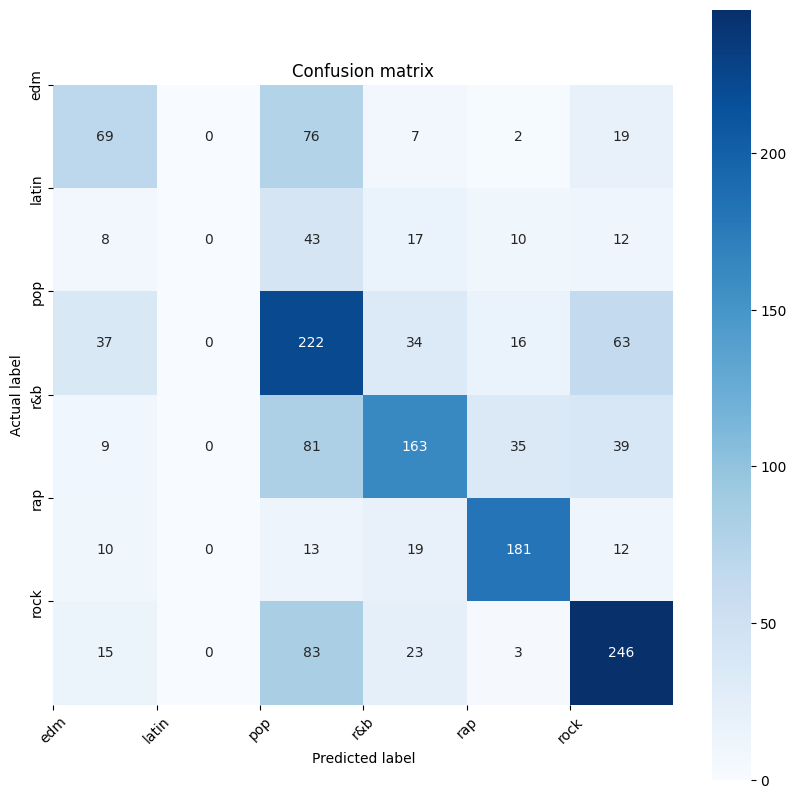

              precision    recall  f1-score   support

         edm       0.47      0.40      0.43       173
       latin       0.00      0.00      0.00        90
         pop       0.43      0.60      0.50       372
         r&b       0.62      0.50      0.55       327
         rap       0.73      0.77      0.75       235
        rock       0.63      0.66      0.65       370

    accuracy                           0.56      1567
   macro avg       0.48      0.49      0.48      1567
weighted avg       0.54      0.56      0.55      1567



In [55]:
# plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

# plot confusion matrix with seaborn
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
# divide by the sum of each row
# cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]
# fill row with 0 if all elements are 0
cm[np.isnan(cm)] = 0
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='d')  # Change format specifier to '.2f'
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
# change label into genre
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.savefig('confusion_matrix.png')
plt.show()

# print macro and micro average, accuracy, precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))

